# Multi-scenario Multi-objective robust decision making (Multi-scenario MORDM)

In this script, the multi-scenario MORDM analysis is used to find a set of robust solutions for the flood risk management of the IJssel river.

MORDM has four main steps:

(i)	    **problem formulation** based on a systems analytical problem definition framework 

(ii)	**searching** for candidate solutions that optimize multiple objectives by using multi-objective evolutionary algorithms 

(iii)	generating an ensemble of scenarios to **explore** the effects of uncertainties 

(iv)	using **scenario discovery** to detect the vulnerabilities of candidate solutions and improving the candidate solutions




# Search for candidate solutions
The analysis is based on problem formulation 2.

The MORDM analysis is based on problem formulation 3. We used 10000 nfe's since the optimization starts to converge after 10000 nfe's. Additionally we use an epsilon of 0.25 to find a balance between an adequate number of solutions and computational costs. Moreover, we don't want too many solutions since this overcomplicates the rest of the analyses.

For the reference scenario (step 2a in multi-scenario MORDM), average valures are used for the uncertainties as no no common reference scenario was defined by the actors.

In [1]:
from problem_formulation import get_model_for_problem_formulation
from ema_workbench import ema_logging, MultiprocessingEvaluator, Scenario
from ema_workbench.em_framework.optimization import EpsilonProgress

In [2]:
model, planning_steps = get_model_for_problem_formulation(2)


reference_scenario = Scenario('reference', **{'discount rate 0': 2.5, 'discount rate 1': 2.5, 'discount rate 2': 2.5, 'A.0_ID flood wave shape': 66, 
                                              'A.1_Bmax': 160, 'A.1_pfail': 0.5, 'A.1_Brate': 1.5, 
                                              'A.2_Bmax': 160, 'A.2_pfail': 0.5, 'A.2_Brate': 1.5, 
                                              'A.3_Bmax': 160, 'A.3_pfail': 0.5, 'A.3_Brate': 1.5,
                                              'A.4_Bmax': 160, 'A.4_pfail': 0.5, 'A.4_Brate': 1.5, 
                                              'A.5_Bmax': 160, 'A.5_pfail': 0.5, 'A.5_Brate': 1.5})

In [3]:
convergence_metrics = [EpsilonProgress()]
nfe = 10000
# number of functional evaluations -> how often the algorithm runs to approach optimum, based on convergence considerations (and computational resources)
# "Note also that there might be a difference between the specified number of nfe (250 in this case) and the actual number of nfe. The default algorithm is population based and the nfe-based stopping condition is only checked after evaluating an entire generation"

epsilon = [0.25,] * len(model.outcomes)
# When you run the optimization and it calculates the pareto efficiency, the model uses epsilon to specify how equal the points on the pareto front have to be, the lower the epsilon, the more equal the values have to be and the fewer possible policies we will get
# maximum distance to be translated by the approximation set in order to dominate the reference set
# sensitive to gaps in the pareto front
## a low value is desired!



In [4]:
ema_logging.log_to_stderr(ema_logging.INFO)
with MultiprocessingEvaluator(model) as evaluator:
    total = evaluator.optimize(nfe=nfe,
                                              searchover='levers',
                                              epsilons=epsilon,
                                              convergence=convergence_metrics,
                                              reference=reference_scenario)

[MainProcess/INFO] pool started with 4 workers
10067it [1:37:02,  1.73it/s]
[MainProcess/INFO] optimization completed, found 43 solutions
[MainProcess/INFO] terminating pool


In [5]:
archive, convergence = total
print(len(archive))

43


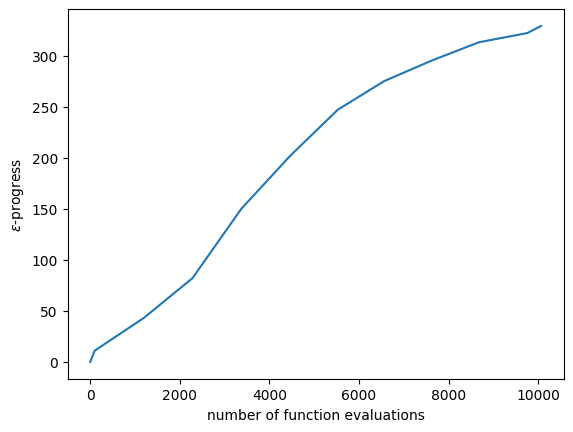

In [6]:
import matplotlib.pyplot as plt
import numpy as np
archive, convergence = total
fig, ax = plt.subplots()
ax.plot(convergence.nfe, convergence.epsilon_progress)
ax.set_ylabel('$\epsilon$-progress')

ax.set_xlabel('number of function evaluations')
plt.show()

Epsilon progress is used to calculate the convergence. 
As can be seen in the plot above the optimization is converged after 10000 function evaluations. 

In [7]:
from ema_workbench import save_results
archive, convergence = total
save_results(total, 'MORDM_10000_0.25_pf1.tar.gz'.format(nfe))

KeyError: 'epsilon_progress'

/Users/Mira/opt/anaconda3/envs/py311/lib/python3.11/site-packages/ema_workbench/analysis/prim.py:30: ImportWarning: altair based interactive inspection not available
  warnings.warn(("altair based interactive " "inspection not available"), ImportWarning)


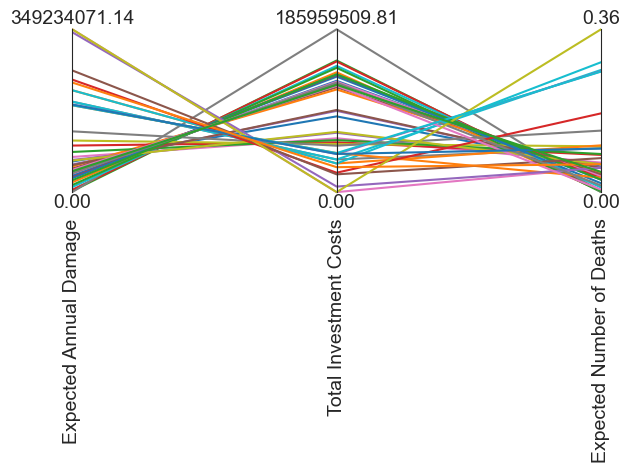

In [8]:
from ema_workbench.analysis import parcoords

data = archive.loc[:, [o.name for o in model.outcomes]]
limits = parcoords.get_limits(data)
#limits.loc[0, ['utility', 'inertia', 'reliability', 'max_P']] = 0

paraxes = parcoords.ParallelAxes(limits)
paraxes.plot(data)
#paraxes.invert_axis('max_P')
plt.show()

In [17]:
#plt.boxplot(archive.loc[:, ['Expected Number of Deaths']])
archive.loc[:, ['Expected Number of Deaths']].squeeze().median()

0.053678988490570914

## Re-evaluate candidate solutions under uncertainty
The optimization resulted in a large number of candidate solutions. These need to be re-evaluated under uncertainty. Therefore, 100 scenarios are explored per scenario. Exploring over more scenarios results in computational costs that are too high. 

Since the one of the main objectives of Rijkswaterstaat is safety, an extra constraint is set. A policy with an average expected number of deaths higher than 0.001 is not acceptable. Therefore, another constraint is added. This also reduces the number of policies that needs to be re-evaluated and thus the computational costs. 

In [25]:
archive.loc[archive['Expected Number of Deaths'] < 0.05]

,0_RfR 0,0_RfR 1,0_RfR 2,1_RfR 0,1_RfR 1,1_RfR 2,2_RfR 0,2_RfR 1,2_RfR 2,3_RfR 0,...,A.3_DikeIncrease 2,A.4_DikeIncrease 0,A.4_DikeIncrease 1,A.4_DikeIncrease 2,A.5_DikeIncrease 0,A.5_DikeIncrease 1,A.5_DikeIncrease 2,Expected Annual Damage,Total Investment Costs,Expected Number of Deaths
1,0,0,0,0,0,0,0,0,0,0,...,0,2,0,0,2,0,0,2.107266e+07,1.368151e+08,0.002389
2,0,0,0,0,0,0,0,0,0,0,...,0,3,0,0,3,0,0,2.314824e+06,1.503063e+08,0.000268
3,0,0,0,0,0,0,0,0,0,0,...,0,2,0,0,3,0,0,4.894689e+06,1.491849e+08,0.003672
5,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,2,0,0,5.051035e+07,1.197315e+08,0.039990
7,0,0,0,0,0,0,0,0,1,0,...,0,6,0,0,4,0,0,0.000000e+00,1.859595e+08,0.000000
8,0,0,0,0,0,0,0,1,0,0,...,0,2,0,0,1,0,0,4.056852e+07,1.245225e+08,0.037117
9,0,0,0,0,0,0,0,0,0,0,...,0,2,0,0,3,0,0,1.075193e+07,1.441606e+08,0.010247
10,0,0,0,0,0,0,0,1,0,0,...,0,2,0,0,2,0,0,3.604097e+07,1.270635e+08,0.033093
11,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,1,0,0,5.502405e+07,1.171904e+08,0.044001
12,0,0,0,0,0,0,0,0,0,0,...,0,2,0,0,3,0,0,1.510838e+07,1.419560e+08,0.002165


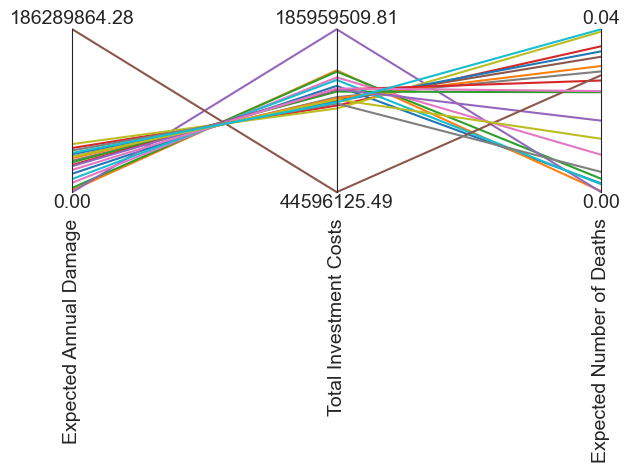

In [26]:
from ema_workbench.analysis import parcoords

archive_subspace = archive.loc[archive['Expected Number of Deaths'] < 0.05]

data = archive_subspace.loc[:, [o.name for o in model.outcomes]]
limits = parcoords.get_limits(data)
#limits.loc[0, ['utility', 'inertia', 'reliability', 'max_P']] = 0

paraxes = parcoords.ParallelAxes(limits)
paraxes.plot(data)
#paraxes.invert_axis('max_P')
plt.show()

In [27]:
policies = archive_subspace
policies = policies.drop([o.name for o in model.outcomes], axis=1)
policies

,0_RfR 0,0_RfR 1,0_RfR 2,1_RfR 0,1_RfR 1,1_RfR 2,2_RfR 0,2_RfR 1,2_RfR 2,3_RfR 0,...,A.2_DikeIncrease 2,A.3_DikeIncrease 0,A.3_DikeIncrease 1,A.3_DikeIncrease 2,A.4_DikeIncrease 0,A.4_DikeIncrease 1,A.4_DikeIncrease 2,A.5_DikeIncrease 0,A.5_DikeIncrease 1,A.5_DikeIncrease 2
1,0,0,0,0,0,0,0,0,0,0,...,0,4,0,0,2,0,0,2,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,4,0,0,3,0,0,3,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,4,0,0,2,0,0,3,0,0
5,0,0,0,0,0,0,0,1,0,0,...,0,3,0,0,0,0,0,2,0,0
7,0,0,0,0,0,0,0,0,1,0,...,0,3,0,0,6,0,0,4,0,0
8,0,0,0,0,0,0,0,1,0,0,...,0,3,0,0,2,0,0,1,0,0
9,0,0,0,0,0,0,0,0,0,0,...,0,4,0,0,2,0,0,3,0,0
10,0,0,0,0,0,0,0,1,0,0,...,0,3,0,0,2,0,0,2,0,0
11,0,0,0,0,0,0,0,1,0,0,...,0,3,0,0,0,0,0,1,0,0
12,0,0,0,0,0,0,0,0,0,0,...,0,3,0,0,2,0,0,3,0,0


In [28]:
from ema_workbench import Policy

policies_to_evaluate = []

for i, policy in policies.iterrows():
    policies_to_evaluate.append(Policy(str(i), **policy.to_dict()))

Now the constraint is set, the policies can be re-evaluated over the 100 scenarios. 

In [29]:
from ema_workbench import SequentialEvaluator

n_scenarios = 100
with MultiprocessingEvaluator(model) as evaluator:
    results = evaluator.perform_experiments(n_scenarios,
                                            policies_to_evaluate)


[MainProcess/INFO] pool started with 4 workers
[MainProcess/INFO] performing 100 scenarios * 20 policies * 1 model(s) = 2000 experiments
100%|██████████████████████████████████████| 2000/2000 [24:59<00:00,  1.33it/s]
[MainProcess/INFO] experiments finished
[MainProcess/INFO] terminating pool


In [30]:
from ema_workbench import save_results
save_results(results, 'MORDM_100_scen_nfe10000_0.25.tar.gz'.format(nfe))

[MainProcess/INFO] results saved successfully to /Users/Mira/Documents/GitHub/epa1361_open/final assignment/MORDM_100_scen_nfe10000_0.25.tar.gz


In [31]:
experiments, outcomes = results


# Scenario discovery

To explore the range of values for the uncertainties that result in the outcomes of interest, scenario discovery is performed. The scenario discovery will consider the expected number of deaths. While a constraint was already set to keep the average number of death below 0.001, it is also important that the number of deaths are distributed equally. Therefore the scenario discovery will find the range of values for the uncertainties that result in the expected number of deaths being below 0.001 for all locations. 

Before performing scenario discovery, the experiments dataset needs to be cleaned since it also includes the values of the levers. This could disturb the analysis, therefore the columns with lever values are removed from the dataset.

In [9]:
from ema_workbench import load_results

results = load_results('FINAL_MORDM_data.gz')
experiments, outcomes = results 

In [10]:
experiments_noDI = experiments.drop(labels=['A.1_DikeIncrease 0','A.1_DikeIncrease 1','A.1_DikeIncrease 2','A.2_DikeIncrease 0','A.2_DikeIncrease 1','A.2_DikeIncrease 2','A.3_DikeIncrease 0','A.3_DikeIncrease 1','A.3_DikeIncrease 2','A.4_DikeIncrease 0','A.4_DikeIncrease 1','A.4_DikeIncrease 2','A.5_DikeIncrease 0','A.5_DikeIncrease 1','A.5_DikeIncrease 2', 'policy'], axis =1)
cleaned_experiments = experiments_noDI.drop(labels=['0_RfR 0','0_RfR 1','0_RfR 2','1_RfR 0','1_RfR 1','1_RfR 2','2_RfR 0','2_RfR 1','2_RfR 2','3_RfR 0','3_RfR 1','3_RfR 2','4_RfR 0','4_RfR 1','4_RfR 2','EWS_DaysToThreat','sum_deaths','A1ExpDeaths','A2ExpDeaths','A3ExpDeaths','A4ExpDeaths','A5ExpDeaths'], axis =1)

In [11]:
from ema_workbench.analysis import prim
from ema_workbench import ema_logging
ema_logging.log_to_stderr(ema_logging.INFO);

x = cleaned_experiments

#total_costs = outcomes['A.1 Total Costs']+outcomes['A.2 Total Costs']+outcomes['A.3 Total Costs']+outcomes['A.4 Total Costs']+outcomes['A.5 Total Costs']

#y = total_costs < 1300000000

#y = outcomes['RfR Total Costs'] <850000000

#y = outcomes['Expected Evacuation Costs'] <= 5000

y = (outcomes['A.1_Expected Number of Deaths'] <= 0.001)  & (outcomes['A.2_Expected Number of Deaths'] <= 0.001) & (outcomes['A.3_Expected Number of Deaths'] <= 0.001) & (outcomes['A.4_Expected Number of Deaths'] <= 0.001) & (outcomes['A.5_Expected Number of Deaths'] <= 0.001)
prim_alg = prim.Prim(x,y, threshold = 0.5, peel_alpha = 0.01)
box = prim_alg.find_box()

[MainProcess/INFO] model dropped from analysis because only a single category
[MainProcess/INFO] 24000 points remaining, containing 2788 cases of interest
[MainProcess/INFO] mean: 0.5425, mass: 0.05, coverage: 0.23350071736011477, density: 0.5425 restricted_dimensions: 12


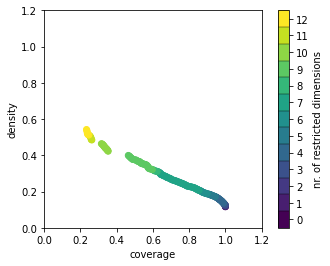

In [14]:
import matplotlib.pyplot as plt
box.show_tradeoff()
plt.savefig('tradeoff density coverage.png')
plt.show()

It is ideal to have an equal tradeoff between density and coverage. However, as can be seen in the plot, PRIM had some difficulties finding a good explanation for this problem. Box 140 was chosen to be investigated because this box is one of the middle cases in the plot and is thus providing a better tradeoff than for example the cases at the sides of the plot

coverage    0.580703
density     0.325886
id               140
mass           0.207
mean        0.325886
res_dim            9
Name: 140, dtype: object

                           box 140              \
                               min         max   
A.4_Bmax                 30.268631  340.378072   
A.3_Bmax                 30.070395  339.431348   
A.2_Bmax                 30.279349  347.731481   
A.2_pfail                 0.454222    0.999607   
A.3_pfail                 0.306581    0.999865   
A.1_pfail                 0.208943    0.985963   
A.5_pfail                 0.165827    0.999798   
A.4_pfail                 0.096789    0.999955   
A.0_ID flood wave shape   3.000000  130.000000   

                                                                      
                                                           qp values  
A.4_Bmax                                  [-1.0, 0.2578534779364206]  
A.3_Bmax                                 [-1.0, 0.28295928666131775]  
A.2_Bmax     

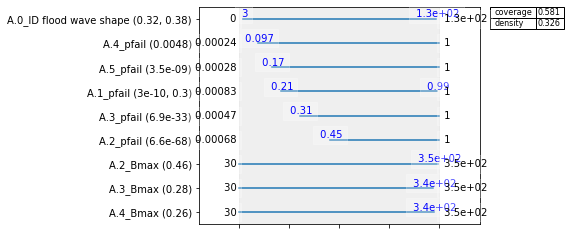

In [15]:
box.inspect(140)
box.inspect(140,style = 'graph')
plt.savefig('ranges of uncertainties.png')
plt.show()

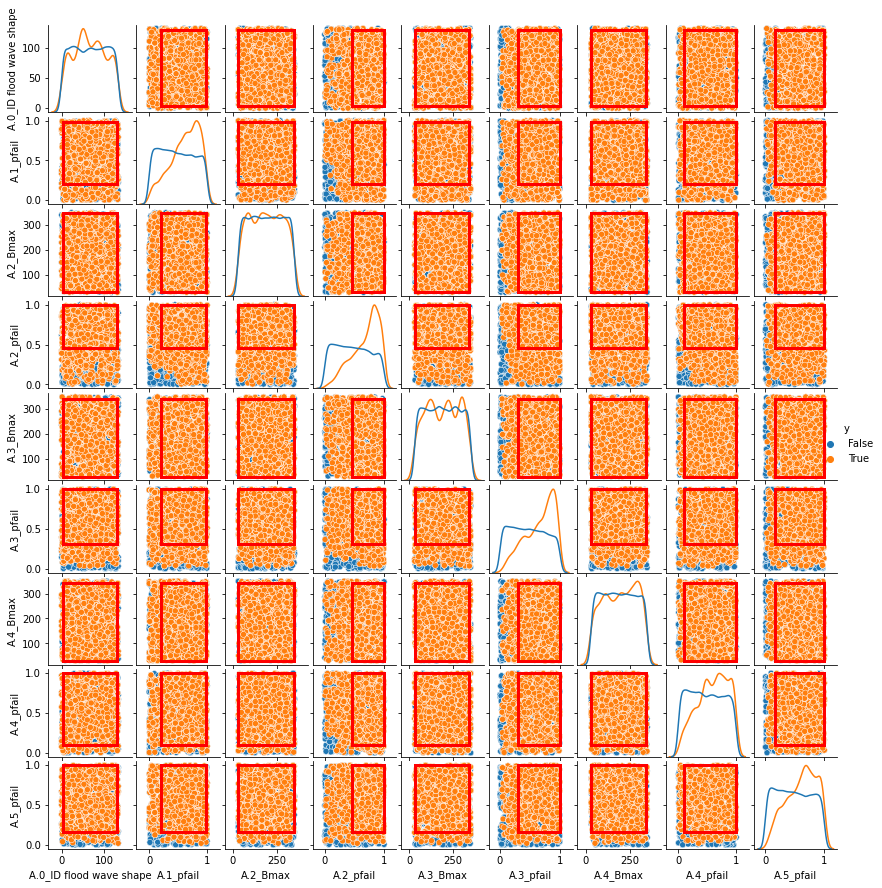

In [16]:
box.select(140)
box.show_pairs_scatter()
fig = plt.gcf()
fig.set_size_inches(12,12)
plt.savefig('scatter plots.png')
plt.show()

## Scenario Discovery (selection of 4 scenarios for multi-scenario MORDM)

### worst case scenarios

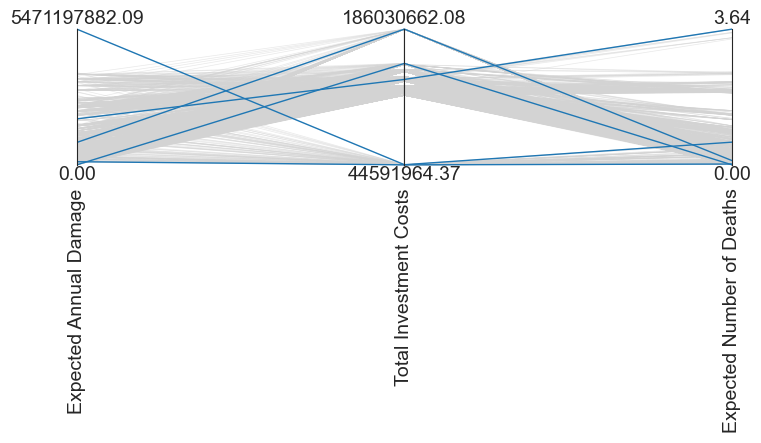

In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from ema_workbench.analysis import parcoords

# conditional on y
all_data = pd.DataFrame({k:v for k,v in outcomes.items()})

# let's get the unique indices for the minima and maxima across 
# all objectives
indices = pd.concat([all_data.idxmax(), all_data.idxmin()]).unique()

limits = parcoords.get_limits(all_data)
axes = parcoords.ParallelAxes(limits)

# we set the linewidth lower, and make the lines slightly transpartant using alpha
# this often helps reveal patterns in the results.
axes.plot(all_data, color='lightgrey', lw=0.5, alpha=0.5)
axes.plot(all_data.iloc[indices, :], color=sns.color_palette()[0], lw=1)
#axes.invert_axis('max_P')

fig = plt.gcf()
fig.set_size_inches((8, 4))

plt.show()

In [34]:
print(all_data.idxmax())
print(all_data.idxmin())

Expected Annual Damage       1571
Total Investment Costs        427
Expected Number of Deaths    1357
dtype: int64
Expected Annual Damage        192
Total Investment Costs       1593
Expected Number of Deaths     192
dtype: int64


In [38]:
experiments.columns

Index(['A.0_ID flood wave shape', 'A.1_Bmax', 'A.1_Brate', 'A.1_pfail',
       'A.2_Bmax', 'A.2_Brate', 'A.2_pfail', 'A.3_Bmax', 'A.3_Brate',
       'A.3_pfail', 'A.4_Bmax', 'A.4_Brate', 'A.4_pfail', 'A.5_Bmax',
       'A.5_Brate', 'A.5_pfail', 'discount rate 0', 'discount rate 1',
       'discount rate 2', '0_RfR 0', '0_RfR 1', '0_RfR 2', '1_RfR 0',
       '1_RfR 1', '1_RfR 2', '2_RfR 0', '2_RfR 1', '2_RfR 2', '3_RfR 0',
       '3_RfR 1', '3_RfR 2', '4_RfR 0', '4_RfR 1', '4_RfR 2',
       'EWS_DaysToThreat', 'A.1_DikeIncrease 0', 'A.1_DikeIncrease 1',
       'A.1_DikeIncrease 2', 'A.2_DikeIncrease 0', 'A.2_DikeIncrease 1',
       'A.2_DikeIncrease 2', 'A.3_DikeIncrease 0', 'A.3_DikeIncrease 1',
       'A.3_DikeIncrease 2', 'A.4_DikeIncrease 0', 'A.4_DikeIncrease 1',
       'A.4_DikeIncrease 2', 'A.5_DikeIncrease 0', 'A.5_DikeIncrease 1',
       'A.5_DikeIncrease 2', 'scenario', 'policy', 'model'],
      dtype='object')

In [39]:
# also all we need are the uncertainty columns
selected = experiments.loc[[1571, 427, 1357], ['A.0_ID flood wave shape', 'A.1_Bmax', 'A.1_Brate', 'A.1_pfail',
       'A.2_Bmax', 'A.2_Brate', 'A.2_pfail', 'A.3_Bmax', 'A.3_Brate',
       'A.3_pfail', 'A.4_Bmax', 'A.4_Brate', 'A.4_pfail', 'A.5_Bmax',
       'A.5_Brate', 'A.5_pfail', 'discount rate 0', 'discount rate 1',
       'discount rate 2']]
selected

,A.0_ID flood wave shape,A.1_Bmax,A.1_Brate,A.1_pfail,A.2_Bmax,A.2_Brate,A.2_pfail,A.3_Bmax,A.3_Brate,A.3_pfail,A.4_Bmax,A.4_Brate,A.4_pfail,A.5_Bmax,A.5_Brate,A.5_pfail,discount rate 0,discount rate 1,discount rate 2
1571,115,301.384136,1.0,0.045658,186.274738,1.0,0.592465,72.513207,1.0,0.006313,202.817071,1.5,0.700924,56.879577,1.5,0.648832,4.5,1.5,1.5
427,110,227.327231,1.5,0.533239,268.897796,1.0,0.320138,86.540938,1.5,0.715182,44.004448,1.0,0.673566,40.704342,1.5,0.006018,4.5,3.5,2.5
1357,82,234.995341,10.0,0.315625,303.623379,1.5,0.502928,186.016256,10.0,0.016242,74.587919,10.0,0.167747,139.108064,1.5,0.429882,2.5,4.5,3.5


In [40]:
from ema_workbench import Scenario

scenarios = [Scenario(f"{index}", **row) for index, row in selected.iterrows()]


In [2]:
import pandas as pd

### Eker & Kwakkel method

In [3]:
from ema_workbench import load_results
experiments, outcomes = load_results('data/ox-final-policy-results.tar.gz')

In [7]:
results = experiments, outcomes

In [8]:
outcomes

{'Expected Annual Damage': array([1.91927982e+09, 2.83584454e+09, 2.55002268e+09, ...,
        0.00000000e+00, 0.00000000e+00, 2.79567661e+06]),
 'Dike Investment Costs': array([        0,         0,         0, ..., 200979261, 200979261,
        200979261]),
 'RfR Investment Costs': array([0.000e+00, 0.000e+00, 0.000e+00, ..., 2.058e+08, 2.058e+08,
        2.058e+08]),
 'Evacuation Costs': array([0., 0., 0., ..., 0., 0., 0.]),
 'Expected Number of Deaths': array([1.37673832, 1.89794837, 1.77650694, ..., 0.        , 0.        ,
        0.00281787])}

In [11]:
from sklearn import preprocessing

experiments_of_interest = experiments.loc[y]
outcomes_df = pd.DataFrame({k:v[y] for k,v in outcomes.items()})

# normalize outcomes on unit interval to ensure equal weighting of outcomes
x = outcomes_df.values 
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
normalized_outcomes = pd.DataFrame(x_scaled, columns=outcomes_df.columns)


In [ ]:
import itertools

n_scen = experiments.loc[y].shape[0]
indices = range(n_scen)
set_size = 4
n_scen
combinations = itertools.combinations(indices, set_size)
combinations = list(combinations)

In [ ]:
print(len(combinations))

Error: Session cannot generate requests

In [ ]:
import random

sampled_combinations = random.sample(combinations, 100000)

In [ ]:
from concurrent.futures import ProcessPoolExecutor
import os
import functools
from scipy.spatial.distance import pdist, squareform

# the relevant code is in a .py file to esnure parallization works within the notebook
from assignment_9_scenario_selection import find_maxdiverse_scenarios

# calculate the pairwise distances between the normalized outcomes
distances = squareform(pdist(normalized_outcomes.values))

cores = os.cpu_count()
partial_function = functools.partial(find_maxdiverse_scenarios, distances)

# setup the pool of workers and split the calculations over the set of cores
with ProcessPoolExecutor(max_workers=cores) as executor:
    worker_data = np.array_split(sampled_combinations, cores)
    results = [e for e in executor.map(partial_function, worker_data)]
    results = list(itertools.chain.from_iterable(results))

In [ ]:
results.sort(key=lambda entry:entry[0], reverse=True)
most_diverse = results[0]
most_diverse

In [ ]:
from ema_workbench import Scenario

selected = experiments.loc[most_diverse[1], ['b', 'delta', 'mean', 'q', 'stdev']]
scenarios = [Scenario(f"{index}", **row) for index, row in selected.iterrows()]

for scenario in scenarios:
    print(scenario)

In [36]:
from ema_workbench.em_framework.optimization import ArchiveLogger

ImportError: cannot import name 'load_archive' from 'ema_workbench.em_framework.optimization' (/Users/Mira/opt/anaconda3/envs/py311/lib/python3.11/site-packages/ema_workbench/em_framework/optimization.py)

In [44]:
ArchiveLogger.load_archives('MORDM_10000_0.25_pf1.tar.gz')

IndexError: list index out of range

## Multi-Scenario Multi-Objective MORDM

In [ ]:
from ema_workbench import MultiprocessingEvaluator, ema_logging
from ema_workbench.em_framework.evaluators import BaseEvaluator

from ema_workbench.em_framework.optimization import (ArchiveLogger,
                                                     EpsilonProgress,
                                                     to_problem, epsilon_nondominated)

ema_logging.log_to_stderr(ema_logging.INFO)

def optimize(scenario, nfe, model, epsilons):
    results = []
    convergences = []
    problem = to_problem(model, searchover="levers")

    with MultiprocessingEvaluator(model) as evaluator:
        for i in range(5):
            convergence_metrics = [
                ArchiveLogger(
                    "./archives",
                    [l.name for l in model.levers],
                    [o.name for o in model.outcomes],
                    base_filename=f"assignemnt_9_{scenario.name}_seed_{i}.tar.gz",
                ),
                EpsilonProgress(),
            ]

            result, convergence = evaluator.optimize(nfe=nfe, searchover='levers',
                                         convergence=convergence_metrics,
                                         epsilons=epsilons,
                                         reference=scenario)

            results.append(result)
            convergences.append(convergence)
    
    # merge the results using a non-dominated sort  
    reference_set = epsilon_nondominated(results, epsilons, problem)    
            
    return reference_set, convergences


results = []
for scenario in scenarios:
    epsilons = [0.05,]*len(model.outcomes)
    
    # note that 100000 nfe is again rather low to ensure proper convergence
    results.append(optimize(scenario, 1e5, model, epsilons))


In [ ]:
from platypus import Hypervolume
from ema_workbench.em_framework.optimization import rebuild_platypus_population


def calculate_convergence_metrics(problem, archives_file):
    hv = Hypervolume(minimum=[0, 0, 0, 0], maximum=[12, 3, 1, 1])
    archives = ArchiveLogger.load_archives(archives_file)
    metrics = []
    for nfe, archive in archives.items():
        population = rebuild_platypus_population(archive, problem)
        metrics.append(dict(hypervolume=hv.calculate(population), nfe=nfe))
        
    metrics = pd.DataFrame.from_dict(metrics)
    metrics.sort_values(by="nfe", inplace=True, ignore_index=True)    
    return metrics


problem = to_problem(model, searchover="levers")
convergence_calculations = []
for (refset, eps_progress), scenario in zip(results, scenarios):
    for seed, seed_eps in zip(range(5), eps_progress):
        archive_file = f"./archives/assignemnt_9_{scenario.name}_seed_{seed}.tar.gz"
        metrics = calculate_convergence_metrics(problem, archive_file)
        metrics["seed"] = seed
        metrics["scenario"] = scenario.name
        metrics["epsilon_progress"] = seed_eps.epsilon_progress   
        
        convergence_calculations.append(metrics)
convergence = pd.concat(convergence_calculations, ignore_index=True)

In [ ]:
import matplotlib as mpl
import seaborn as sns


fig, (ax1, ax2) = plt.subplots(ncols=2)

colors = sns.color_palette()

legend_items = []
for (scenario_name, scores), color in zip(convergence.groupby("scenario"), colors):
    # we use this for a custom legend
    legend_items.append((mpl.lines.Line2D([0, 0], [1, 1], c=color), scenario_name))
    for seed, score in scores.groupby("seed"):
        ax1.plot(score.nfe, score.hypervolume, c=color, lw=1)
        ax2.plot(score.nfe, score.epsilon_progress, c=color, lw=1)


ax1.set_ylabel('hypervolume')
ax1.set_xlabel('nfe')
ax2.set_ylabel('$\epsilon$ progress')
ax2.set_xlabel('nfe')

# create our custom legend
artists, labels = zip(*legend_items)
fig.legend(artists, labels, bbox_to_anchor=(1,0.9))

plt.show()

# Robustness metrics

Another important objective of Rijkswaterstaat is that policies should be robust. Therefore, the robustness of the differnt policies is calculated. For all policies the signal_to_noise ratio and the maximum regret is calculated. For both robustness metrics a function is created. 

In [22]:
experiments = experiments.replace(np.nan,'None')

In [23]:
results = experiments, outcomes

**Signal-to-noise ratio**

In [4]:
def s_to_n(data, direction):
    mean = np.mean(data)
    std = np.std(data)
    
    if direction==ScalarOutcome.MAXIMIZE:
        return mean/std
    else:
        return mean*std
    

In [24]:
from ema_workbench import ScalarOutcome
import pandas as pd
import numpy as np
from problem_formulation import get_model_for_problem_formulation
model, planning_steps = get_model_for_problem_formulation(2)


experiments, outcomes = results

overall_scores = {}
for policy in np.unique(experiments['policy']):
    scores = {}
    
    logical = experiments['policy']==policy
    
    for outcome in model.outcomes:
        value  = outcomes[outcome.name][logical]
        sn_ratio = s_to_n(value, outcome.kind)
        scores[outcome.name] = sn_ratio
    overall_scores[policy] = scores
s_to_n_ = pd.DataFrame.from_dict(overall_scores).T
s_to_n_

,Expected Annual Damage,Dike Investment Costs,RfR Investment Costs,Evacuation Costs,Expected Number of Deaths
Dike,1.527892e+13,0.0,0.0,0.000000e+00,0.000025
Evacuation,1.930786e+18,0.0,0.0,1.971902e+09,0.025221
FinalDebate,4.149939e+16,0.0,0.0,0.000000e+00,0.020821
FirstDebate,4.829422e+17,0.0,0.0,0.000000e+00,0.215736
None,1.930786e+18,0.0,0.0,0.000000e+00,1.751470
RfR,4.499701e+17,0.0,0.0,0.000000e+00,0.578733


In [29]:
import seaborn as sns
import matplotlib.pyplot as plt

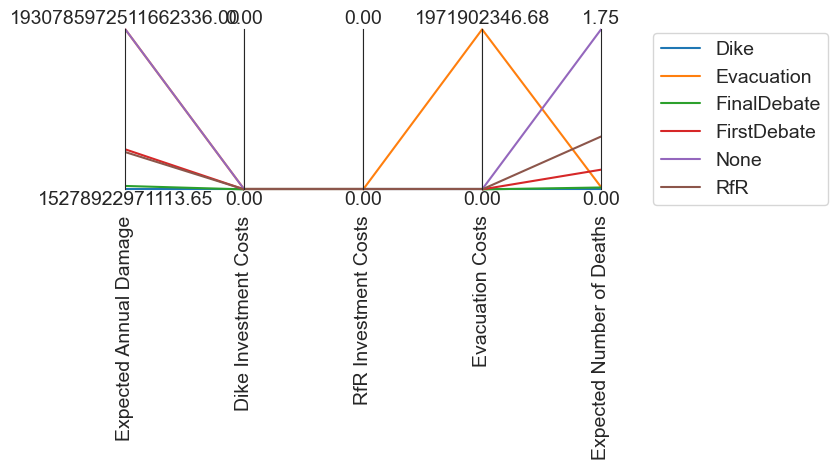

In [30]:
from ema_workbench.analysis import parcoords

data = s_to_n_
limits = parcoords.get_limits(data)

paraxes = parcoords.ParallelAxes(limits)
#paraxes.plot(data)
for i, (index, row) in enumerate(data.iterrows()):
    paraxes.plot(row.to_frame().T, label=str(index), color=sns.color_palette()[i])
paraxes.legend()

plt.savefig('s_to_n parcoords')
plt.show()

Since we want to minimize all outcomes, a low signal-to-noise ratio is desired. 


**Minimum regret**

Regret is the difference between the performance of a policy in a specific scenario and the best possible performance of a policy in that scenario. The minimum regret is the minimum regret value of a policy across all scenarios. 
The lowest maximum regret values are desired since all outcomes are minimized. To avoid negative values, the absolute difference is calculated.

In [32]:
def calculate_regret(data, best):
    return np.abs(best-data)
    

The best possible performance in a specific scenario is calculated by using pandas. This code is based on the calculation of maximum regret in the code of assignment 8.
Source: https://github.com/quaquel/epa1361_open/blob/master/Week%205-6%20-%20robustness%20and%20direct%20search/assignment%208%20-%20model%20answer.ipynb

In [72]:
experiments, outcomes = results

overall_regret = {}
min_regret = {}
for outcome in model.outcomes:
    policy_column = experiments['policy']
    
    # create a DataFrame with all the relevent information
    # i.e., policy, scenario_id, and scores
    data = pd.DataFrame({outcome.name: outcomes[outcome.name], 
                         "policy":experiments['policy'],
                         "scenario":experiments['scenario']})
    
    # reorient the data by indexing with policy and scenario id
    data = data.pivot(index='scenario', columns='policy')
    
    # flatten the resulting hierarchical index resulting from 
    # pivoting, (might be a nicer solution possible)
    data.columns = data.columns.get_level_values(1)
    
    data_min = pd.DataFrame()
    
    for i in range(0,data.shape[1],1):
        data_min = pd.concat([data_min, data.min(axis=1)], axis=1)
    
    data_min = data_min.set_axis(data.columns, axis=1)
    
    outcome_regret = (data_min - data).abs()
    
    overall_regret[outcome.name] = outcome_regret
    min_regret[outcome.name] = outcome_regret.min()
    

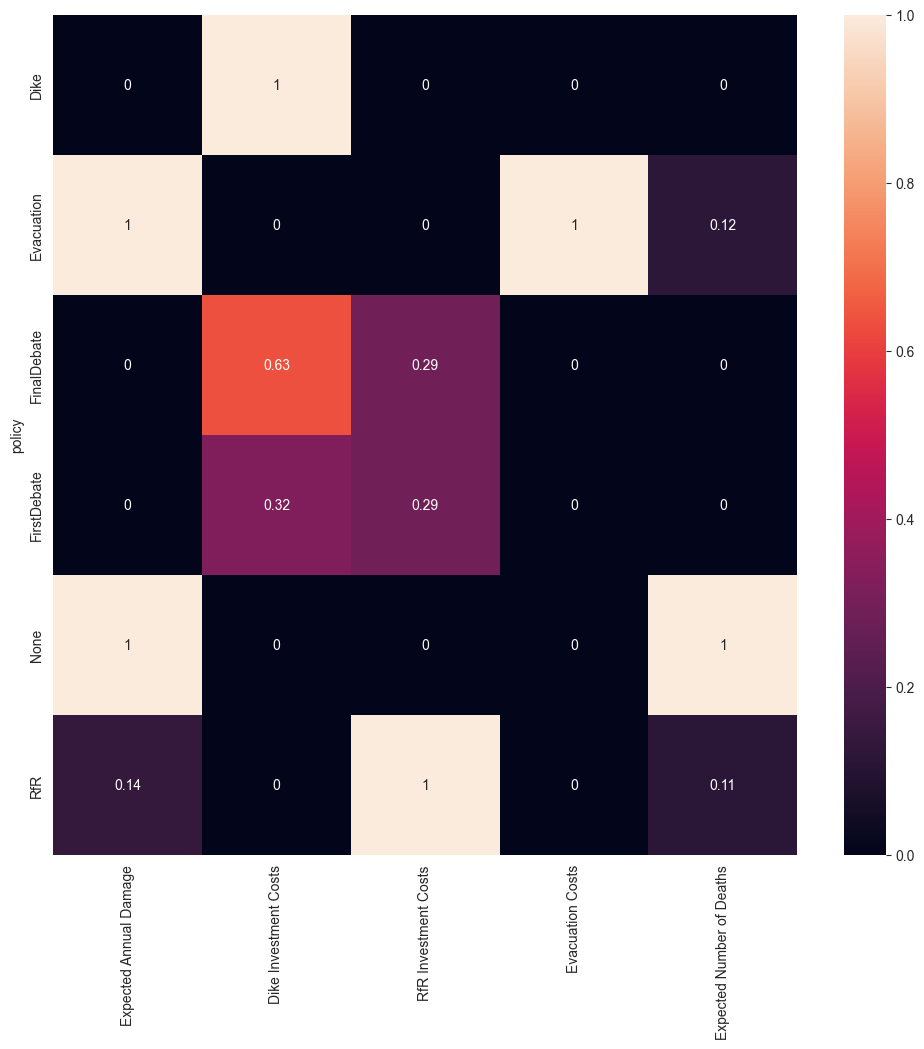

In [85]:
import seaborn as sns

min_regret = pd.DataFrame(min_regret)
plt.figure(figsize = (12,14))
sns.heatmap(min_regret/min_regret.max(), annot=True)
plt.subplots_adjust(bottom = 0.28)
#sns.set(rc={'figure.figuresize':(15,8)})
#fig.tight_layout()
#fig.set_size_inches(12,12)
plt.savefig('heatmap_regret')
plt.show()

In [86]:
min_regret

,Expected Annual Damage,Dike Investment Costs,RfR Investment Costs,Evacuation Costs,Expected Number of Deaths
policy,,,,,
Dike,0.000000e+00,317408714,0.0,0.000000,0.000000
Evacuation,6.728413e+07,0,0.0,3634.812729,0.010726
FinalDebate,0.000000e+00,200979261,205800000.0,0.000000,0.000000
FirstDebate,0.000000e+00,102391648,205800000.0,0.000000,0.000000
None,6.728413e+07,0,0.0,0.000000,0.089380
RfR,9.257845e+06,0,710400000.0,0.000000,0.009834


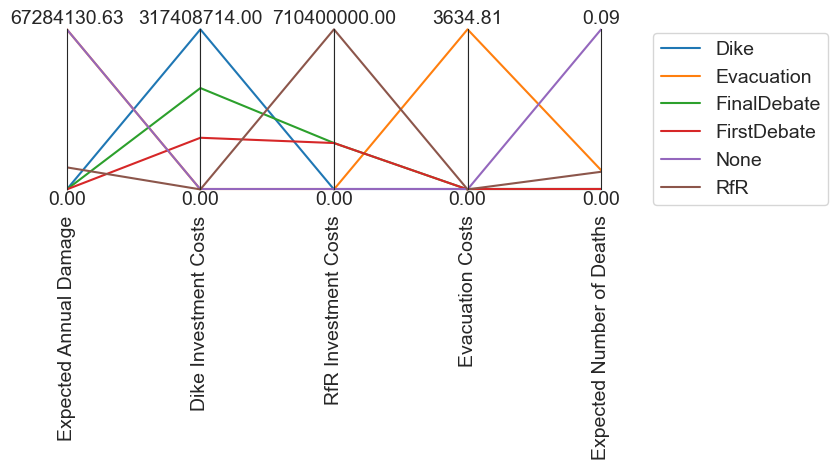

In [89]:
data = min_regret

colors = sns.color_palette(n_colors=len(data))

limits = parcoords.get_limits(data)
#limits.loc[0, ['utility', 'inertia', 'reliability', 'max_P']] = 0

paraxes = parcoords.ParallelAxes(limits)
for i, (index, row) in enumerate(data.iterrows()):
    paraxes.plot(row.to_frame().T, label=str(index), color=colors[i])
paraxes.legend()
plt.savefig('regret parcoords')
plt.show()